# Server-side Feature Inference Attacks against Split Learning: MNIST Digits

Experiments with the effects of different learning rate on the reconstruction error.

## Import packages and dataset

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import sl_with_attack
from sl_with_attack import *
from datasets import *

xpriv, xpub = load_mnist()

## Setting up hyperparameters and util functions

In [2]:
batch_size = 64
id_setup = 4
hparams = [{
    'WGAN' : True,
    'gradient_penalty' : 500.,
    'style_loss' : None,
    'lr_f' :  0.00001,
    'lr_tilde' : 0.00001,
    'lr_D' : 0.0001,
    'lr_classify': 0.000001,
    },
    {
    'WGAN' : True,
    'gradient_penalty' : 500.,
    'style_loss' : None,
    'lr_f' :  0.00001,
    'lr_tilde' : 0.00001,
    'lr_D' : 0.0001,
    'lr_classify': 0.00001,
    },
    {
    'WGAN' : True,
    'gradient_penalty' : 500.,
    'style_loss' : None,
    'lr_f' :  0.00001,
    'lr_tilde' : 0.00001,
    'lr_D' : 0.0001,
    'lr_classify': 0.0001,
    },
    {
    'WGAN' : True,
    'gradient_penalty' : 500.,
    'style_loss' : None,
    'lr_f' :  0.00001,
    'lr_tilde' : 0.00001,
    'lr_D' : 0.0001,
    'lr_classify': 0.001,
    }
]

# 1000 iterations should be enough to show the curves
iterations = 1000
log_frequency = 20

def plot_log(ax, x, y, label=None, color='blue'):
    ax.plot(x, y, color=color)
    ax.grid()
    if label is not None:
        ax.set(title=label)

## Model architectures

In [3]:
def ResBlock(inputs, dim, ks=3, bn=False, activation='relu', reduce=1):
    x = inputs
    
    stride = reduce
    
    if bn:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x = tf.keras.layers.Activation(activation)(x)
    x = tf.keras.layers.Conv2D(dim, ks, stride, padding='same')(x)
    
    if bn:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x = tf.keras.layers.Activation(activation)(x)
    x = tf.keras.layers.Conv2D(dim, ks, padding='same')(x)
    
    if reduce > 1:
        inputs = tf.keras.layers.Conv2D(dim, ks, stride, padding='same')(inputs)
    
    return inputs + x

def f(input_shape):
    xin = tf.keras.layers.Input(input_shape)
    x = tf.keras.layers.Conv2D(64, 3, 1, padding='same')(xin)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(2)(x)
    x = ResBlock(x, 64)
    x = ResBlock(x, 128, reduce=2)
    x = ResBlock(x, 128)
    x = ResBlock(x, 256, reduce=2)
    return tf.keras.Model(xin, x)

def g(input_shape, class_num):
    xin = tf.keras.layers.Input(input_shape)
    x = xin
    x = ResBlock(xin, 256)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    if class_num == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = class_num

    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(units, activation=activation)(x)
    return tf.keras.Model(xin, x)

def encoder(input_shape):
    xin = tf.keras.layers.Input(input_shape)
    act = None
    x = tf.keras.layers.Conv2D(64, 3, 2, padding='same', activation=act)(xin)
    x = tf.keras.layers.Conv2D(128, 3, 2, padding='same', activation=act)(x)
    x = tf.keras.layers.Conv2D(256, 3, 2, padding='same', activation=act)(x)
    x = tf.keras.layers.Conv2D(256, 3, 1, padding='same')(x)
    return tf.keras.Model(xin, x)

def decoder(input_shape, channels=3):
    xin = tf.keras.layers.Input(input_shape)
    act = None
    x = tf.keras.layers.Conv2DTranspose(256, 3, 2, padding='same', activation=act)(xin)
    x = tf.keras.layers.Conv2DTranspose(128, 3, 2, padding='same', activation=act)(x)
    x = tf.keras.layers.Conv2DTranspose(channels, 3, 2, padding='same', activation="tanh")(x)
    return tf.keras.Model(xin, x)

def discriminator(input_shape):
    xin = tf.keras.layers.Input(input_shape)
    x = tf.keras.layers.Conv2D(256, 3, 1, padding='same')(xin)
    bn = False
    x = ResBlock(x, 256, bn=bn)
    x = ResBlock(x, 256, bn=bn)
    x = ResBlock(x, 256, bn=bn)
    x = ResBlock(x, 256, bn=bn)
    x = ResBlock(x, 256, bn=bn)
    x = ResBlock(x, 256, bn=bn)
    x = tf.keras.layers.Conv2D(256, 3, 2, padding='same')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1)(x)
    return tf.keras.Model(xin, x)

In [4]:
models = (f, g, encoder, decoder, discriminator)

## Passive Attack

In [5]:
passives = []
log_passives = []
for hparam in hparams:
    print("lr = " + str(hparam["lr_classify"]))
    passive = sl_with_attack(models, xpriv, xpub, id_setup-1, batch_size, hparam, 10, server_attack="passive")
    log_passive = passive(iterations, verbose=False, progress_bar=False, log_frequency=log_frequency)
    passives.append(passive)
    log_passives.append(log_passive)

lr = 1e-06
RUNNING...
lr = 1e-05
RUNNING...
lr = 0.0001
RUNNING...
lr = 0.001
RUNNING...


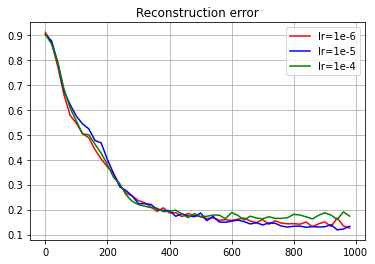

In [8]:
plt.title("Reconstruction error")
plt.plot(np.arange(0, len(log_passives[0])) * log_frequency, log_passives[0][:,3], color='red')
plt.plot(np.arange(0, len(log_passives[0])) * log_frequency, log_passives[1][:,3], color='blue')
plt.plot(np.arange(0, len(log_passives[0])) * log_frequency, log_passives[2][:,3], color='green')
# plt.plot(np.arange(0, len(log_passives[0])) * log_frequency, log_passives[3][:,3], color='black')
plt.legend(['lr=1e-6', 'lr=1e-5', 'lr=1e-4',], loc='upper right')
plt.grid()

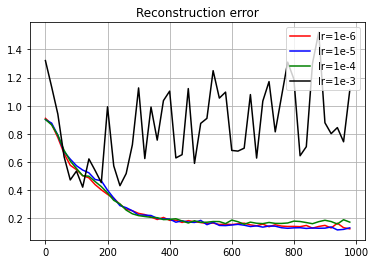

In [9]:
plt.title("Reconstruction error")
plt.plot(np.arange(0, len(log_passives[0])) * log_frequency, log_passives[0][:,3], color='red')
plt.plot(np.arange(0, len(log_passives[0])) * log_frequency, log_passives[1][:,3], color='blue')
plt.plot(np.arange(0, len(log_passives[0])) * log_frequency, log_passives[2][:,3], color='green')
plt.plot(np.arange(0, len(log_passives[0])) * log_frequency, log_passives[3][:,3], color='black')
plt.legend(['lr=1e-6', 'lr=1e-5', 'lr=1e-4','lr=1e-3'], loc='upper right')
plt.grid()

Oops! We got a problem here.

## Save the outputs

In [10]:
np.savetxt('./log/lr/1e-6.csv', log_passives[0], delimiter=',')
np.savetxt('./log/lr/1e-5.csv', log_passives[1], delimiter=',')
np.savetxt('./log/lr/1e-4.csv', log_passives[2], delimiter=',')
np.savetxt('./log/lr/1e-3.csv', log_passives[3], delimiter=',')